### In the previous notebook we created a weakly supervised data. Now Using that labeled data we will try to build models

In [1]:
%matplotlib inline
import spacy
import random
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.utils import shuffle
from src import FeatureGeneration
from src.trainer import train_model
from sklearn.model_selection import train_test_split
from src.utility import print_classifaction_report, save_model

I0725 00:33:37.918547 139634134677312 file_utils.py:41] PyTorch version 1.5.0+cu101 available.
I0725 00:33:38.703907 139634134677312 file_utils.py:57] TensorFlow version 2.2.0 available.
/home/rita/anaconda3/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


### Short note on the datasets we generated.

We have created 2 datasets, in our previous notebook.
1. weak supervised_data(full): which contains all the lines of the document and corresponding labels.
2. weak supervised_data(pruned): Mostly address which we are interested to identify is comming from the top section of document. We are only annotating the top 40% of the documents. For the further expriments in this notebook we will use pruned dataset.

In [2]:
dataset = pd.read_csv('dataset/supervised_dataset(pruned).csv')
feature_dataset = FeatureGeneration(dataset).transform #feature engineering.
feature_dataset = feature_dataset.merge(dataset,  on=['text']).drop_duplicates(subset=['text']) 

In [1]:
# After multiple experiments, it seems like these features are really important
# in general for modelling address vs non-address 

imp_columns = ['avg_token_length', 'more_then_avg', 'alpha_count',
               'stop_word_count', 'punct_count', 'digit_count', 'alpha_num_count',
               'number_of_title_tokens', 'not_alphabet_count', 'number_of_tokens',
               'dolar_count','address_key_words','noun_count','upper_case']

In [17]:
feature_dataset = shuffle(feature_dataset, random_state=24)
train_data, test_data = train_test_split(feature_dataset, random_state = 56)
X_train, y_train = train_data[imp_columns], train_data['class_2_target']
X_test, y_test = test_data[imp_columns], test_data['class_2_target']

## Train and Test data distribution

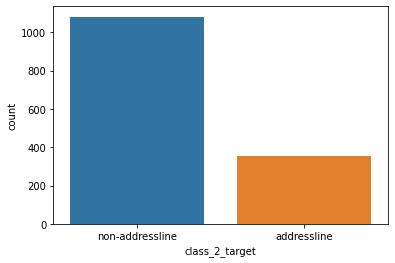

In [5]:
sns.countplot(train_data['class_2_target'],label="Count")
plt.show()

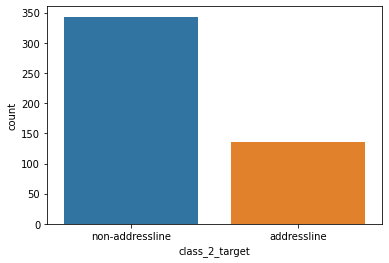

In [6]:
sns.countplot(test_data['class_2_target'],label="Count")
plt.show()

I0725 00:33:50.456829 139634134677312 utils.py:129] Note: NumExpr detected 12 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
I0725 00:33:50.458562 139634134677312 utils.py:141] NumExpr defaulting to 8 threads.


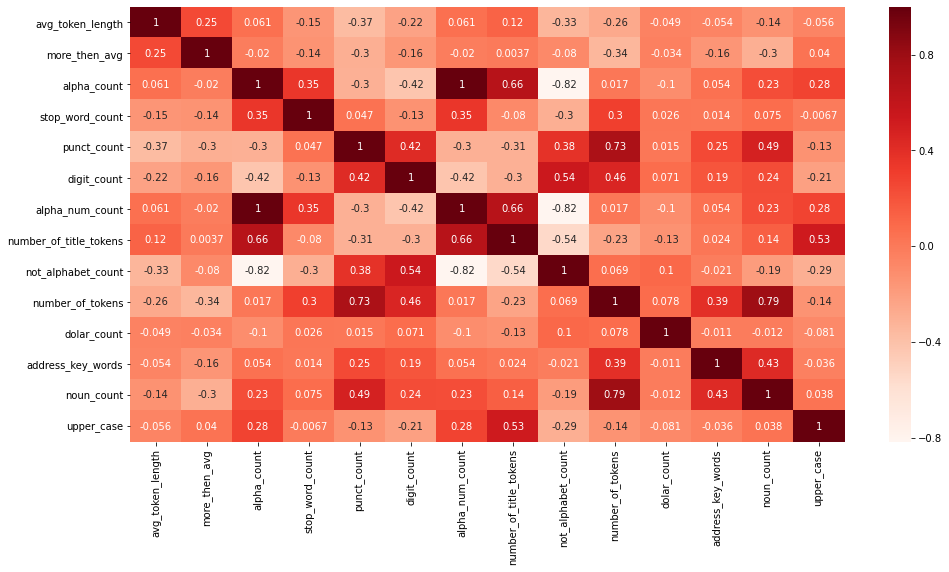

In [7]:
#Lets check that how good features are:
plt.figure(figsize=(16,8))
cor = feature_dataset[imp_columns].corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()

In [2]:
#now lets try a couple of differnent models based on these features

### Random forest model

In [8]:
rf_model = train_model('random_forest',X_train, y_train)
print_classifaction_report(rf_model, X_test, y_test)
print('Train dataset\n')
print_classifaction_report(rf_model, X_train, y_train)

[[ 15 121]
 [  3 340]]
                 precision    recall  f1-score   support

    addressline       0.83      0.11      0.19       136
non-addressline       0.74      0.99      0.85       343

       accuracy                           0.74       479
      macro avg       0.79      0.55      0.52       479
   weighted avg       0.76      0.74      0.66       479

Train dataset

[[  45  308]
 [   1 1080]]
                 precision    recall  f1-score   support

    addressline       0.98      0.13      0.23       353
non-addressline       0.78      1.00      0.87      1081

       accuracy                           0.78      1434
      macro avg       0.88      0.56      0.55      1434
   weighted avg       0.83      0.78      0.72      1434



In [18]:
svc_model = train_model('svm',X_train, y_train)
save_model(svc_model, 'models/svm.pkl')
print_classifaction_report(svc_model, X_test, y_test)
print('Train dataset\n')
print_classifaction_report(svc_model, X_train, y_train)

[[ 47  62]
 [ 27 343]]
                 precision    recall  f1-score   support

    addressline       0.64      0.43      0.51       109
non-addressline       0.85      0.93      0.89       370

       accuracy                           0.81       479
      macro avg       0.74      0.68      0.70       479
   weighted avg       0.80      0.81      0.80       479

Train dataset

[[ 257  123]
 [  40 1014]]
                 precision    recall  f1-score   support

    addressline       0.87      0.68      0.76       380
non-addressline       0.89      0.96      0.93      1054

       accuracy                           0.89      1434
      macro avg       0.88      0.82      0.84      1434
   weighted avg       0.88      0.89      0.88      1434



### Observation:
1. If you notice the results, f1 score is not much differing between the training and testing. Even if we compare the random forest and SVM , Nothing really change here.
2. The other observation is that the model looks like an **underfitted** model.

### What next (How to overcome from the underfit issue):
1. Improve the features.
2. Generate more data.
(a small note: We don't have very good tagged data, our tagged data can also be noisy so it is difficult to say that it is actually underfitted, but i think it is mostly underfitted)

### More observations: 

some more observations on the test data predictions to understand the models better, which will help us to improve our feature engineering & cases where we are failing/tricky or where we might need just more data.

In [19]:
test_data['svm_prediction'] = svc_model.predict(X_test[imp_columns])

/home/rita/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [20]:
false_negative = test_data.query(f'svm_prediction == "non-addressline" and class_2_target == "addressline"')
false_positive = test_data.query(f'svm_prediction == "addressline" and class_2_target == "non-addressline"')

In [21]:
print(f'False Negative: {len(false_negative)}')
print(f'False Positive: {len(false_positive)}')

False Negative: 62
False Positive: 27


In [137]:
for row in false_negative.sample(n=10).itertuples():
    if row.line_id < 20:
        print(f'text: {row.text}\nline_type: {row.class_3_target}')
        print('-'*100)

text: Okolona
line_type: partial-addressline
----------------------------------------------------------------------------------------------------
text: Address : GPU Wittheu, Tower A11, 27th-28th Floor Invoice No. : INV-1745013CL - R
line_type: partial-addressline
----------------------------------------------------------------------------------------------------
text: 46 Alexandra Road Currency Exch. Rate to SGO
line_type: partial-addressline
----------------------------------------------------------------------------------------------------
text: 618809 Tel: + 65 62653711
line_type: partial-addressline
----------------------------------------------------------------------------------------------------
text: 4290 Victoria Court Fort Fairfield California US 04742
line_type: partial-addressline
----------------------------------------------------------------------------------------------------
text: California 440397 DATE: 17-DEC-2017
line_type: partial-addressline
---------------------

In [140]:
for row in false_positive.sample(n=10).itertuples():
    print(f'text: {row.text}\nline_type: {row.class_3_target}')
    print('-'*100)

text: OF 12 STOREY BUILDING WITH 3 BASEMENT CARPARK FOR
line_type: non-addressline
----------------------------------------------------------------------------------------------------
text: 1st to 3rd Progressive Claim
line_type: non-addressline
----------------------------------------------------------------------------------------------------
text: Office Day 2 Works-Willis Watson Towers
line_type: non-addressline
----------------------------------------------------------------------------------------------------
text: 7% GST on S$ 392.52 Total GST 27.48
line_type: non-addressline
----------------------------------------------------------------------------------------------------
text: MMSG00633/17 17-DEC-2017 Net 60 Days
line_type: non-addressline
----------------------------------------------------------------------------------------------------
text: Tel: Email: +65 info@somwh.com.sg 6269145 Fax: +65 6352286 Website: www.somwh.com
line_type: non-addressline
-----------------------

### Observations on the false negative predictions:
- If We observe when the address line is well written without junk we are not able to pick up the line as addesslines. What if we try to add more clean text adderss in to the dataset. For example , **44 Jalans Buraho, 44 Jalans Buraho,**.This is a clean addressline but there is not punct or digit or any sort of noise, and our model fails here!!!
- Most of the cases, model is not able to detect the partial addressas well.

### Observations on false positive predictions:
- We are using the partial matching algorthim to tag the data. Which leads us to tag so much non-address lines as addressline.
- We do have organization name tagged as address line. False positive can exist in the groundtruth itself.
- Some time company name is tagged as addresses(Grond truth data), we can see that is happeing in model prediction as well. Document conatins more than two addresses than also we are not tagging the data. Which can lead model to fail. for exmple **Bank Address : 12 Marinal Bouleavard, DBSS Central, Marinal Road, Financial** actual data says that, this line is **non-addressline**. However it is actually a address line.

(One more observation is that in most cases, since the groundtruth itself is quite noisy this happens.)

### Closing notes:

Here, My End goal is not only to detect the addressline. We need to further classify to the buyer and vendor as well 
As such the most important question is How can I improve my data quality to decrease the False negative? 

- As we know, the current dataset is imbalanced(even after some earlier processing).
Hence, what if we do some Data augmentation, and see if that improves anything?